In [23]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt

In [24]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [25]:
speciesname = "Be_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
#num_tapered = molecule['num_tapered']

Be_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/usr/local/lib64/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


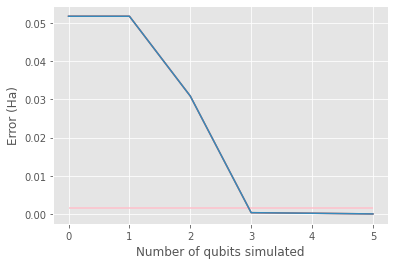

In [26]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

Exact ground state energy:  -14.40365512171954
[(0.3333333335946387, '01001'), (0.33229651727306736, '01010'), (0.16666666650648967, '01100'), (0.1661189547138682, '01101'), (0.0009227362769283821, '11001')]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


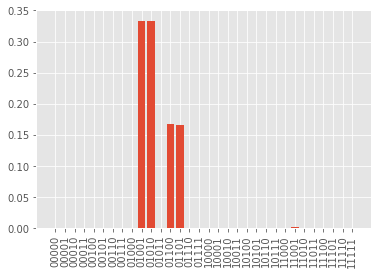

In [28]:
import numpy as np
from qat.dqs.hamiltonians import SpinHamiltonian

ham_rot = cs_tools.rotate_operator(mol_circ.ham_rotations, ham)
full_terms = [Term(coeff, op, list(range(num_qubits))) for op, coeff in ham_rot.items()]
ham_spin = SpinHamiltonian(nqbits=num_qubits, pauli_terms=full_terms)
ham_matrix = ham_spin.get_matrix()
eigvals, eigvecs = np.linalg.eigh(ham_matrix)
gs = sorted(list(zip(eigvals, eigvecs)), key=lambda x:x[0])[0]

print("Exact ground state energy: ", gs[0])
basis_states = [bit.int_to_bin(i, num_qubits) for i in range(2**num_qubits)]
sig_states = sorted(list(zip(abs(gs[1])**2, basis_states)), key=lambda x:-x[0])
print(sig_states[:5])

fig, ax = plt.subplots()
l1=ax.bar(basis_states, [abs(a)**2 for a in gs[1]])
l2=ax.set_xticklabels(basis_states, rotation=90)

In [33]:
nonconstate = mol_circ.reference_state()
print(nonconstate)
print(cs_tools.rotate_operator(mol_circ.ham_rotations, {''.join(blank_op):1}))
anz={}
for amp, state in sig_states[:4]:
    differs=[index for index, b in enumerate(state) if nonconstate[index]!=b]
    pot_ops=[]
    for op in uccsd.keys():
        diff_bits = {op[i] for i in differs}
        same_bits = {op[i] for i in range(num_qubits) if i not in differs}
        if diff_bits in [{'X'}, {'Y'}, {'X', 'Y'}] and same_bits in [{'I'},{'Z'},{'I', 'Z'}]:
            pot_ops.append(op)
    blank_op = ['I' for i in range(num_qubits)]
    for i in differs:
        blank_op[i] = 'Y'
    unrot_ops = cs_tools.rotate_operator(mol_circ.ham_rotations, {''.join(blank_op):1})
    print(unrot_ops)

01011
00100
{'ZZIZZ': 1.3207745626178302e-06, 'ZIIYZ': 0.7214346440063115, 'ZZIXZ': -0.6924825300509336}
{'YZYIY': 1.0}
{'ZXZZX': -0.7214346440075206, 'ZXZXX': 1.2677701554057557e-06, 'ZYZIX': -0.6924825300497731}
{'XYXZZ': 0.7214346440075206, 'XYXXZ': -1.2677701554057557e-06, 'XXXIZ': -0.6924825300497731}


In [21]:
anz = cs_tools.rotate_operator(mol_circ.ham_rotations, {'IIIII':1})
anz

{'IIIII': 1.0}

In [14]:
#anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF
#anz = {op:uccsd[op] for op in anz_ops}
#anz={'YYYIY':1, 'YYYYY':1}
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()

In [15]:
pauli_terms = [Term(coeff, op, list(range(num_sim_q))) for op, coeff in ham_dict.items()]
hamiltonian = Observable(num_sim_q,
               pauli_terms=pauli_terms)
print("Hamiltonian:", hamiltonian)

Hamiltonian: -12.488597999526664 * I^3 +
-0.8582942510393043 * (ZZ|[0, 2]) +
-0.8582942510393037 * (ZZZ|[0, 1, 2]) +
0.02304318020306532 * (Z|[1]) +
0.8582942510393039 * (ZZ|[1, 2]) +
-0.023043180203062546 * (ZZ|[0, 1]) +
-0.02304318020306378 * (Z|[0]) +
-0.6424707358333475 * (Z|[2]) +
0.004106477226173261 * (XZ|[0, 1]) +
0.01140810864884969 * (YZ|[0, 1]) +
-0.004106477226173261 * (X|[0]) +
-0.01140810864884969 * (Y|[0]) +
-0.004106477226173261 * (YYZ|[0, 1, 2]) +
0.01140810864884969 * (XYZ|[0, 1, 2]) +
0.01140810864884969 * (YXZ|[0, 1, 2]) +
0.004106477226173261 * (XXZ|[0, 1, 2]) +
-0.012124689610585465 * (ZXZ|[0, 1, 2]) +
-0.012124689610585465 * (XZ|[1, 2]) +
-0.043404490470751914 * (ZYX|[0, 1, 2]) +
0.043404490470751914 * (YX|[1, 2]) +
-0.040839242911408766 * (XXX|[0, 1, 2]) +
-0.040839242911408766 * (YYX|[0, 1, 2]) +
-0.040839242911408766 * (YY|[0, 2]) +
-0.040839242911408766 * (YZY|[0, 1, 2]) +
0.014700545277252224 * (YXX|[0, 1, 2]) +
-0.014700545277252224 * (XYX|[0, 1, 2]) +
-0.0

In [16]:
gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
prog = Program()
qbits_reg = prog.qalloc(num_sim_q)
params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

for gate, var_num, q_pos in instructions:
    q_pos = [num_sim_q-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
    if gate == 'RZ':
        prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
    elif gate == 'CX':
        prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
    else:
        prog.apply(gate_dict[gate], qbits_reg[q_pos[0]])

qc = prog.to_circ()

In [17]:
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman
from qat.plugins import SPSAMinimizePlugin
from qat.plugins import PSOMinimizePlugin

theta0 = np.zeros(2**num_sim_q)#mol_circ.init_param
linalg_qpu = LinAlg(use_GPU=False)

optimizer_pso = PSOMinimizePlugin(theta0, max_iter=50, swarm_number=10)
optimizer_spsa = SPSAMinimizePlugin(theta0)
optimizer_scipy = ScipyMinimizePlugin(method="Nelder-Mead",
                                      tol=1e-3,
                                      options={"maxiter": 1000})

qpu = optimizer_scipy | linalg_qpu

job = qc.to_job(job_type="OBS", observable=hamiltonian)

result = qpu.submit(job)

print("Minimum energy =", result.value)
#print("Optimal angles =", result.meta_data["parameters"])

Minimum energy = -14.351880476202037


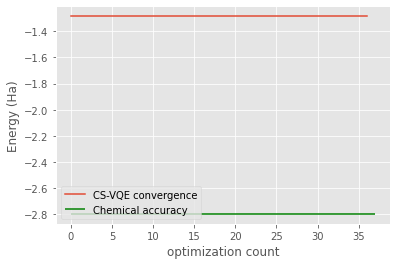

In [18]:
nfev = len(eval(result.meta_data['optimization_trace']))
energy=eval(result.meta_data['optimization_trace'])
plt.plot([np.log10(abs(x-mol_circ.truegs)) for x in energy], label='CS-VQE convergence')
plt.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy')
#plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
plt.xlabel("optimization count")
plt.ylabel("Energy (Ha)")
plt.legend()